# Adding Dynamic Features To Improve Energy Usage Predictions

For updates on the way Sagemaker or AWS behave compared to the notebook code, please refer to https://livebook.manning.com/#!/book/machine-learning-for-business/chapter-7/v-5/83

## Part 1: Load and examine the data

In [1]:
data_bucket = 'mlforbusiness'
subfolder = 'ch07'
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In [2]:
%matplotlib inline

from dateutil.parser import parse
import json
import random
import datetime
import os
from time import sleep

import pandas as pd                               
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

role = sagemaker.get_execution_role()
s3 = s3fs.S3FileSystem(anon=False)
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In this chapter we will be dealing with 5 files. Our meter readings have already been summarised into daily totals and can be found in "Meter Data.csv". We also have a "Site Categories.csv" file which records whether each site belongs to the Retail, Industrial, or Transport industries. We will use this as a static "Category" feature. There is a further file which contains time series data regarding holidays. This is "Site Holidays.csv". Finally we have maximum temperatures in "Site Maxima.csv" These will be our models "dynamic features".

In [3]:
# First we check our meter data
daily_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/meter_data_daily.csv', index_col=0, parse_dates=[0])
daily_df.index.name = None
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_46,Site_47,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,NaN,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,NaN,NaN,NaN,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,NaN,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,NaN,NaN,NaN,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,NaN,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,NaN,NaN,NaN,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,NaN,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,NaN,NaN,NaN,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,NaN,5221.5,929.4,1068.0,767.7,785.8,...,318.24,NaN,NaN,NaN,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [4]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


In [5]:
category_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_categories.csv',index_col=0).reset_index(drop=True)
print(category_df.shape)
print(category_df.Category.unique())
category_df.head()

(48, 2)
['Retail' 'Industrial ' 'Transport']


,Site,Category
0,1,Retail
1,2,Retail
2,3,Retail
3,4,Retail
4,5,Retail


In [6]:
holiday_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_holidays.csv', index_col=0, parse_dates=[0])
print(holiday_df.shape)
print(f'Time series starts at {holiday_df.index[0]} and ends at {holiday_df.index[-1]}')
holiday_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_hol,Site_2_hol,Site_3_hol,Site_4_hol,Site_5_hol,Site_6_hol,Site_7_hol,Site_8_hol,Site_9_hol,Site_10_hol,...,Site_39_hol,Site_40_hol,Site_41_hol,Site_42_hol,Site_43_hol,Site_44_hol,Site_45_hol,Site_46_hol,Site_47_hol,Site_48_hol
2018-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-24,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
2018-12-25,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-26,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
max_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_maximums.csv', index_col=0, parse_dates=[0])
print(max_df.shape)
print(f'Time series starts at {max_df.index[0]} and ends at {max_df.index[-1]}')
max_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_max,Site_2_max,Site_3_max,Site_4_max,Site_5_max,Site_6_max,Site_7_max,Site_8_max,Site_9_max,Site_10_max,...,Site_39_max,Site_40_max,Site_41_max,Site_42_max,Site_43_max,Site_44_max,Site_45_max,Site_46_max,Site_47_max,Site_48_max
2018-12-22,21.5,23.4,24.9,23.1,24.9,25.2,23.4,24.9,23.4,23.9,...,33.2,20.4,20.4,24.9,21.5,21.1,21.1,18.9,18.9,40.9
2018-12-23,29.5,28.4,30.9,27.0,30.9,30.8,28.4,30.9,28.4,30.4,...,27.4,25.5,25.5,30.9,22.6,23.4,23.4,24.5,24.5,34.9
2018-12-24,33.3,35.2,36.6,35.1,36.6,37.0,35.2,36.6,35.2,36.4,...,27.0,33.8,33.8,36.6,25.4,26.8,26.8,33.9,33.9,33.6
2018-12-25,34.7,34.8,37.8,32.4,37.8,37.9,34.8,37.8,34.8,37.5,...,27.1,25.1,25.1,37.8,29.7,30.1,30.1,23.8,23.8,33.8
2018-12-26,37.5,34.8,40.0,32.8,40.0,39.5,34.8,40.0,34.8,40.1,...,27.2,30.2,30.2,40.0,30.5,31.8,31.8,23.7,23.7,29.6
2018-12-27,39.3,41.3,42.8,40.9,42.8,43.7,41.3,42.8,41.3,43.9,...,28.1,36.7,36.7,42.8,32.4,32.4,32.4,33.9,33.9,27.1


## Part 2: Get the data in the right shape

In [8]:
# We need to do this to set freq='D' on the index:
daily_df = daily_df.resample('D').sum()
daily_df = daily_df.replace([0],[None])

In [9]:
daily_df[daily_df.isnull().any(axis=1)].index

DatetimeIndex(['2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
               '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18', '2017-11-19', '2017-11-20',
               '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24',
               '2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', freq='D')

Some sites have missing values for November 2017. We will not impute these but instead train with missing values.
During the prediction step we will only use values from December. So daily_df is already in the right shape!

In [10]:
# How about categoricals?
print(f'{len(category_df[category_df.isnull().any(axis=1)])} sites with missing categories.')

0 sites with missing categories.


In [11]:
# Dynamic features?
print(f'{len(holiday_df[holiday_df.isnull().any(axis=1)])} days with missing holidays.')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures.')

0 days with missing holidays.
54 days with missing maximum temperatures.


In [12]:
# So we have to impute missing temperatures. Weather does not follow a weekly cycle like energu usage does,
# but pandas has a very nice way to impute missing values for this very situation:
max_df = max_df.interpolate(method='time')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures. Problem solved!')

0 days with missing maximum temperatures. Problem solved!


Number of time series: 48


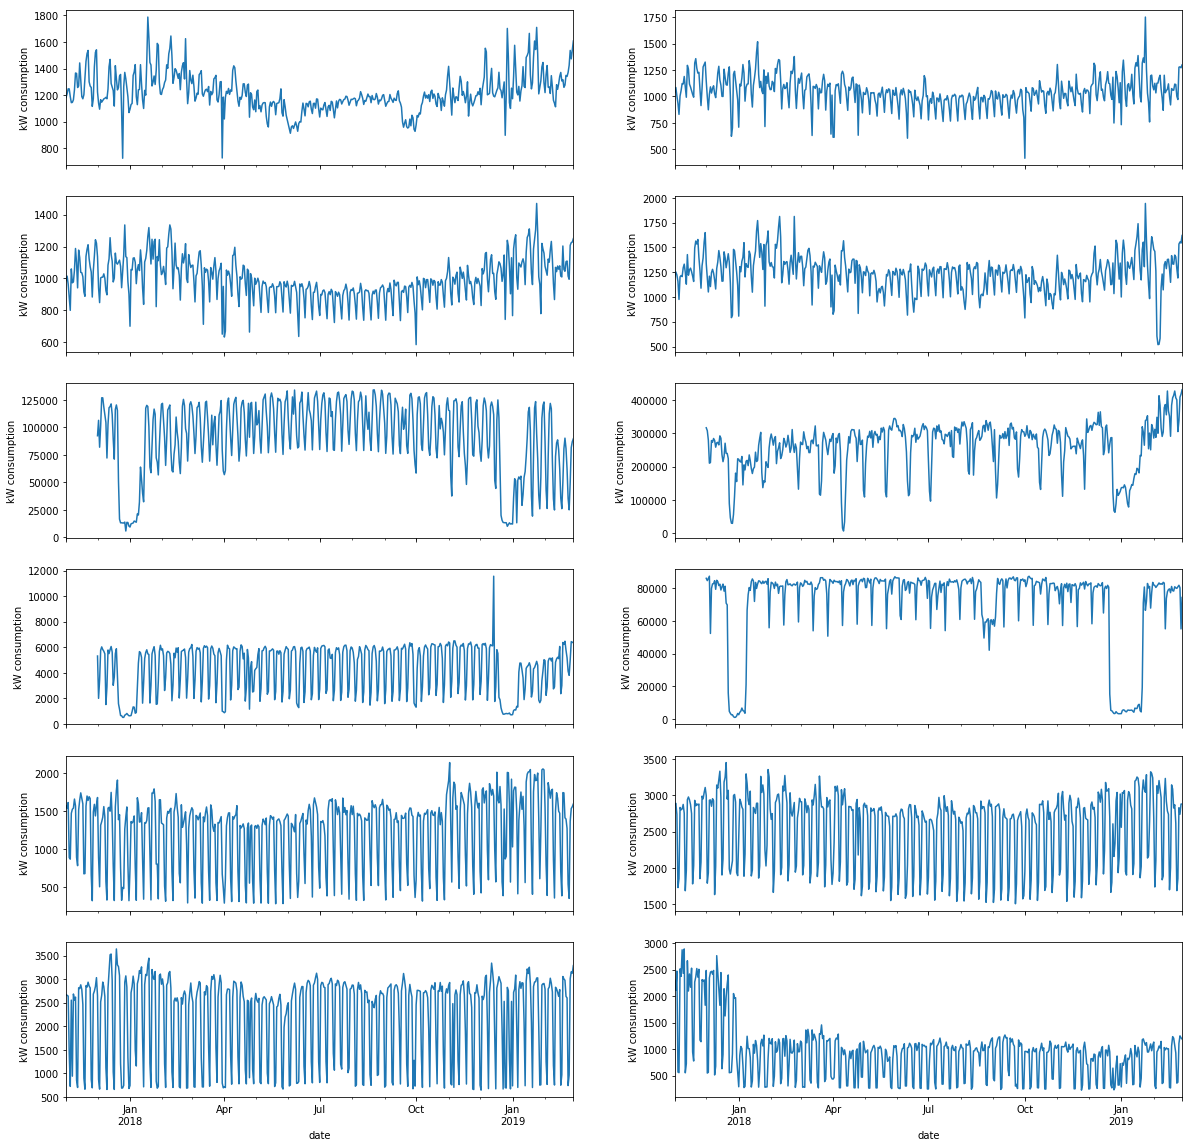

In [13]:
# Confirm visually we are dealing with the same or similar data to chapter 6:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(6, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,26,27,33,39,42,43,46,47]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2019-02-28"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

## Part 3: Create Train and Test Datasets

In [14]:
cats = list(category_df.Category.astype('category').cat.codes)
print(cats)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2]


In [16]:
usage_per_site = [daily_df[col] for col in daily_df.columns]

print(f'Time series covers {len(usage_per_site[0])} days.')
print(f'Time series starts at {usage_per_site[0].index[0]}')
print(f'Time series ends at {usage_per_site[0].index[-1]}') 
usage_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    1184.23
2017-11-02     1210.9
2017-11-03     1247.6
2017-11-04    1246.92
2017-11-05     1189.2
2017-11-06    1143.62
2017-11-07    1145.66
2017-11-08     1165.5
2017-11-09    1239.25
2017-11-10    1366.25
Freq: D, Name: Site_1, dtype: object

In [17]:
# Do the same for our dynamic features
hols_per_site = [holiday_df[col] for col in holiday_df.columns]
    
print(f'Time series covers {len(hols_per_site[0])} days.')
print(f'Time series starts at {hols_per_site[0].index[0]}')
print(f'Time series ends at {hols_per_site[0].index[-1]}') 
hols_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    0
2017-11-02    0
2017-11-03    0
2017-11-04    0
2017-11-05    0
2017-11-06    0
2017-11-07    0
2017-11-08    0
2017-11-09    0
2017-11-10    0
Name: Site_1_hol, dtype: int64

In [18]:
max_per_site = [max_df[col] for col in max_df.columns]
    
print(f'Time series covers {len(max_per_site[0])} days.')
print(f'Time series starts at {max_per_site[0].index[0]}')
print(f'Time series ends at {max_per_site[0].index[-1]}') 
max_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    20.5
2017-11-02    20.9
2017-11-03    16.2
2017-11-04    18.2
2017-11-05    22.1
2017-11-06    17.2
2017-11-07    17.5
2017-11-08    23.1
2017-11-09    28.5
2017-11-10    31.7
Name: Site_1_max, dtype: float64

In [19]:
freq = 'D'
prediction_length = 28

start_date = pd.Timestamp("2017-11-01", freq=freq)
end_training = pd.Timestamp("2019-01-31", freq=freq)
end_testing = end_training + prediction_length*start_date.freq

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2019-01-31 00:00:00, End testing: 2019-02-28 00:00:00


In [20]:
def write_dicts_to_s3(path, data):
    with s3.open(path, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))

In [21]:
# NOTE: We have missing values in ts for November only.
#       Dynamic features must have numeric values for every entry.
training_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist(),
        "dynamic_feat": [
            hols[start_date:end_training].tolist(),
            maxes[start_date:end_training].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]

test_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist(),
        "dynamic_feat": [
            hols[start_date:end_testing].tolist(),
            maxes[start_date:end_testing].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]
            
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

## Part 4: Set up session and configure model

In [22]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(sess.boto_region_name, "forecasting-deepar", "latest")

data_channels = {
    "train": f"{s3_data_path}/train/",
    "test": f"{s3_data_path}/test/"
}
np.random.seed(42)
random.seed(42)

In [23]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
# Reuse the class from Chapter 6:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

## Part 5a: Create model without using additional datasets

First, we will establish a baseline without categorical or dynamic features. Note that this cell is commented out as you only need to run it if you want to see the MAPE without incorporating additional datasets.

In [25]:
# estimator = sagemaker.estimator.Estimator(
#     sagemaker_session=sess,
#     image_name=image_name,
#     role=role,
#     train_instance_count=1,
#     train_instance_type='ml.m4.xlarge',
#     base_job_name='ch7-energy-usage-baseline',
#     output_path=s3_output_path
# )

# estimator.set_hyperparameters(
#     cardinality='ignore', # DISABLES CATEGORICALS FOR BASELINE
#     context_length="90",
#     prediction_length=str(prediction_length),
#     time_freq=freq,
#     epochs="400",
#     early_stopping_patience="40",
#     mini_batch_size="64",
#     learning_rate="5E-4",
#     num_dynamic_feat="ignore", # DISABLE DYNAMIC FEATURES FOR BASELINE
# )

# estimator.fit(inputs=data_channels, wait=True)

# endpoint_name = 'energy-usage-baseline'

# try:
#     sess.delete_endpoint(endpoint_name)
#     print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
#     sleep(30)
# except:
#     pass

# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m4.xlarge',
#     predictor_cls=DeepARPredictor,
#     endpoint_name=endpoint_name)

# # Gather 28 day predictions for all timeseries
# usages = [ts[end_training+1:end_training+28].sum() for ts in usage_per_site]

# predictions= []
# for s in range(len(usage_per_site)):
#     # call the end point to get the 28 day prediction
#     predictions.append(
#         predictor.predict(
#             ts=usage_per_site[s][start_date+30:end_training],
#         )['0.5'].sum()
#     )
    
# print(f'MAPE: {round(mape(usages, predictions),1)}%')    

## Part 5b: Model incorporating additional datasets

In [25]:
%%time
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='ch7-energy-usage-dynamic',
    output_path=s3_output_path
)

estimator.set_hyperparameters(
    context_length="90",
    prediction_length=str(prediction_length),
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    num_dynamic_feat=2,
)

estimator.fit(inputs=data_channels, wait=True)

2019-07-07 02:58:48 Starting - Starting the training job...
2019-07-07 02:58:49 Starting - Launching requested ML instances..................
2019-07-07 03:01:51 Starting - Preparing the instances for training......
2019-07-07 03:02:51 Downloading - Downloading input data...
2019-07-07 03:03:20 Training - Downloading the training image..
Arguments: train
[07/07/2019 03:03:55 INFO 140614380701504] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/07


2019-07-07 03:03:53 Training - Training image download completed. Training in progress.[07/07/2019 03:04:08 INFO 140614380701504] Epoch[5] Batch[0] avg_epoch_loss=7.184848
[07/07/2019 03:04:08 INFO 140614380701504] #quality_metric: host=algo-1, epoch=5, batch=0 train loss <loss>=7.18484783173
[07/07/2019 03:04:09 INFO 140614380701504] Epoch[5] Batch[5] avg_epoch_loss=6.956832
[07/07/2019 03:04:09 INFO 140614380701504] #quality_metric: host=algo-1, epoch=5, batch=5 train loss <loss>=6.95683224996
[07/07/2019 03:04:09 INFO 140614380701504] Epoch[5] Batch [5]#011Speed: 363.36 samples/sec#011loss=6.956832
[07/07/2019 03:04:10 INFO 140614380701504] processed a total of 628 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2095.345973968506, "sum": 2095.345973968506, "min": 2095.345973968506}}, "EndTime": 1562468650.413387, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468648.317968}

[07/07/2019 03:04:10 INFO 14061438

[07/07/2019 03:04:24 INFO 140614380701504] Epoch[12] Batch[5] avg_epoch_loss=6.866794
[07/07/2019 03:04:24 INFO 140614380701504] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=6.86679442724
[07/07/2019 03:04:24 INFO 140614380701504] Epoch[12] Batch [5]#011Speed: 346.86 samples/sec#011loss=6.866794
[07/07/2019 03:04:24 INFO 140614380701504] processed a total of 619 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2030.6458473205566, "sum": 2030.6458473205566, "min": 2030.6458473205566}}, "EndTime": 1562468664.863376, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468662.832117}

[07/07/2019 03:04:24 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=304.810624229 records/second
[07/07/2019 03:04:24 INFO 140614380701504] #progress_metric: host=algo-1, completed 3 % of epochs
[07/07/2019 03:04:24 INFO 140614380701504] #quality_metric: host=algo-1, epoch=12, train loss <loss>=6.

[07/07/2019 03:04:44 INFO 140614380701504] Epoch[21] Batch[10] avg_epoch_loss=6.675649
[07/07/2019 03:04:44 INFO 140614380701504] #quality_metric: host=algo-1, epoch=21, batch=10 train loss <loss>=6.63787250519
[07/07/2019 03:04:44 INFO 140614380701504] Epoch[21] Batch [10]#011Speed: 364.49 samples/sec#011loss=6.637873
[07/07/2019 03:04:44 INFO 140614380701504] processed a total of 697 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2175.3859519958496, "sum": 2175.3859519958496, "min": 2175.3859519958496}}, "EndTime": 1562468684.018116, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468681.842184}

[07/07/2019 03:04:44 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=320.382303338 records/second
[07/07/2019 03:04:44 INFO 140614380701504] #progress_metric: host=algo-1, completed 5 % of epochs
[07/07/2019 03:04:44 INFO 140614380701504] #quality_metric: host=algo-1, epoch=21, train loss <loss>

[07/07/2019 03:04:58 INFO 140614380701504] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1991.5478229522705, "sum": 1991.5478229522705, "min": 1991.5478229522705}}, "EndTime": 1562468698.639868, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468696.647722}

[07/07/2019 03:04:58 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=305.270996909 records/second
[07/07/2019 03:04:58 INFO 140614380701504] #progress_metric: host=algo-1, completed 7 % of epochs
[07/07/2019 03:04:58 INFO 140614380701504] #quality_metric: host=algo-1, epoch=28, train loss <loss>=6.42543692589
[07/07/2019 03:04:58 INFO 140614380701504] loss did not improve
[07/07/2019 03:04:59 INFO 140614380701504] Epoch[29] Batch[0] avg_epoch_loss=6.204153
[07/07/2019 03:04:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=29, batch=0 train loss <loss>=6.20415258408
[07/07/2019 03:04:59 INFO 1406143

[07/07/2019 03:05:19 INFO 140614380701504] Epoch[38] Batch[5] avg_epoch_loss=6.150395
[07/07/2019 03:05:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=38, batch=5 train loss <loss>=6.1503953139
[07/07/2019 03:05:19 INFO 140614380701504] Epoch[38] Batch [5]#011Speed: 368.46 samples/sec#011loss=6.150395
[07/07/2019 03:05:19 INFO 140614380701504] processed a total of 626 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2012.3569965362549, "sum": 2012.3569965362549, "min": 2012.3569965362549}}, "EndTime": 1562468719.801447, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468717.78842}

[07/07/2019 03:05:19 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=311.060683881 records/second
[07/07/2019 03:05:19 INFO 140614380701504] #progress_metric: host=algo-1, completed 9 % of epochs
[07/07/2019 03:05:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=38, train loss <loss>=6.18

[07/07/2019 03:05:39 INFO 140614380701504] Epoch[47] Batch[10] avg_epoch_loss=6.195350
[07/07/2019 03:05:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=47, batch=10 train loss <loss>=6.12923259735
[07/07/2019 03:05:39 INFO 140614380701504] Epoch[47] Batch [10]#011Speed: 364.81 samples/sec#011loss=6.129233
[07/07/2019 03:05:39 INFO 140614380701504] processed a total of 673 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2171.854019165039, "sum": 2171.854019165039, "min": 2171.854019165039}}, "EndTime": 1562468739.144367, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468736.971895}

[07/07/2019 03:05:39 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=309.855673254 records/second
[07/07/2019 03:05:39 INFO 140614380701504] #progress_metric: host=algo-1, completed 12 % of epochs
[07/07/2019 03:05:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=47, train loss <loss>=6

[07/07/2019 03:05:58 INFO 140614380701504] Epoch[56] Batch[10] avg_epoch_loss=6.180373
[07/07/2019 03:05:58 INFO 140614380701504] #quality_metric: host=algo-1, epoch=56, batch=10 train loss <loss>=6.15775623322
[07/07/2019 03:05:58 INFO 140614380701504] Epoch[56] Batch [10]#011Speed: 366.11 samples/sec#011loss=6.157756
[07/07/2019 03:05:58 INFO 140614380701504] processed a total of 708 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2390.313148498535, "sum": 2390.313148498535, "min": 2390.313148498535}}, "EndTime": 1562468758.800283, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468756.409901}

[07/07/2019 03:05:58 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=296.179548066 records/second
[07/07/2019 03:05:58 INFO 140614380701504] #progress_metric: host=algo-1, completed 14 % of epochs
[07/07/2019 03:05:58 INFO 140614380701504] #quality_metric: host=algo-1, epoch=56, train loss <loss>=6

[07/07/2019 03:06:19 INFO 140614380701504] Epoch[66] Batch[5] avg_epoch_loss=6.179776
[07/07/2019 03:06:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=66, batch=5 train loss <loss>=6.17977611224
[07/07/2019 03:06:19 INFO 140614380701504] Epoch[66] Batch [5]#011Speed: 365.76 samples/sec#011loss=6.179776
[07/07/2019 03:06:19 INFO 140614380701504] processed a total of 606 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1980.2360534667969, "sum": 1980.2360534667969, "min": 1980.2360534667969}}, "EndTime": 1562468779.847505, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468777.866704}

[07/07/2019 03:06:19 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=305.996638278 records/second
[07/07/2019 03:06:19 INFO 140614380701504] #progress_metric: host=algo-1, completed 16 % of epochs
[07/07/2019 03:06:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=66, train loss <loss>=6

[07/07/2019 03:06:39 INFO 140614380701504] Epoch[75] Batch[10] avg_epoch_loss=6.187890
[07/07/2019 03:06:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=75, batch=10 train loss <loss>=6.19930562973
[07/07/2019 03:06:39 INFO 140614380701504] Epoch[75] Batch [10]#011Speed: 360.77 samples/sec#011loss=6.199306
[07/07/2019 03:06:39 INFO 140614380701504] processed a total of 667 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2207.345962524414, "sum": 2207.345962524414, "min": 2207.345962524414}}, "EndTime": 1562468799.317911, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468797.110126}

[07/07/2019 03:06:39 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=302.155576165 records/second
[07/07/2019 03:06:39 INFO 140614380701504] #progress_metric: host=algo-1, completed 19 % of epochs
[07/07/2019 03:06:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=75, train loss <loss>=6

[07/07/2019 03:06:59 INFO 140614380701504] Epoch[85] Batch[5] avg_epoch_loss=6.183278
[07/07/2019 03:06:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=85, batch=5 train loss <loss>=6.18327816327
[07/07/2019 03:06:59 INFO 140614380701504] Epoch[85] Batch [5]#011Speed: 365.32 samples/sec#011loss=6.183278
[07/07/2019 03:06:59 INFO 140614380701504] processed a total of 623 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2017.0350074768066, "sum": 2017.0350074768066, "min": 2017.0350074768066}}, "EndTime": 1562468819.842639, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468817.825162}

[07/07/2019 03:06:59 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=308.850696378 records/second
[07/07/2019 03:06:59 INFO 140614380701504] #progress_metric: host=algo-1, completed 21 % of epochs
[07/07/2019 03:06:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=85, train loss <loss>=6

[07/07/2019 03:07:18 INFO 140614380701504] Epoch[94] Batch[10] avg_epoch_loss=6.141714
[07/07/2019 03:07:18 INFO 140614380701504] #quality_metric: host=algo-1, epoch=94, batch=10 train loss <loss>=6.16817932129
[07/07/2019 03:07:18 INFO 140614380701504] Epoch[94] Batch [10]#011Speed: 365.92 samples/sec#011loss=6.168179
[07/07/2019 03:07:18 INFO 140614380701504] processed a total of 642 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2223.721981048584, "sum": 2223.721981048584, "min": 2223.721981048584}}, "EndTime": 1562468838.934015, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468836.709828}

[07/07/2019 03:07:18 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=288.689029317 records/second
[07/07/2019 03:07:18 INFO 140614380701504] #progress_metric: host=algo-1, completed 23 % of epochs
[07/07/2019 03:07:18 INFO 140614380701504] #quality_metric: host=algo-1, epoch=94, train loss <loss>=6

[07/07/2019 03:07:39 INFO 140614380701504] Epoch[104] Batch[5] avg_epoch_loss=6.028851
[07/07/2019 03:07:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=104, batch=5 train loss <loss>=6.02885079384
[07/07/2019 03:07:39 INFO 140614380701504] Epoch[104] Batch [5]#011Speed: 363.29 samples/sec#011loss=6.028851
[07/07/2019 03:07:39 INFO 140614380701504] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1999.2480278015137, "sum": 1999.2480278015137, "min": 1999.2480278015137}}, "EndTime": 1562468859.851982, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468857.852279}

[07/07/2019 03:07:39 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=319.097951558 records/second
[07/07/2019 03:07:39 INFO 140614380701504] #progress_metric: host=algo-1, completed 26 % of epochs
[07/07/2019 03:07:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=104, train loss <los

[07/07/2019 03:07:59 INFO 140614380701504] Epoch[113] Batch[10] avg_epoch_loss=6.114467
[07/07/2019 03:07:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=113, batch=10 train loss <loss>=6.03351783752
[07/07/2019 03:07:59 INFO 140614380701504] Epoch[113] Batch [10]#011Speed: 364.75 samples/sec#011loss=6.033518
[07/07/2019 03:07:59 INFO 140614380701504] processed a total of 663 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2180.6280612945557, "sum": 2180.6280612945557, "min": 2180.6280612945557}}, "EndTime": 1562468879.178737, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468876.997441}

[07/07/2019 03:07:59 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=304.022596839 records/second
[07/07/2019 03:07:59 INFO 140614380701504] #progress_metric: host=algo-1, completed 28 % of epochs
[07/07/2019 03:07:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=113, train loss <

[07/07/2019 03:08:18 INFO 140614380701504] Epoch[123] Batch[0] avg_epoch_loss=6.105791
[07/07/2019 03:08:18 INFO 140614380701504] #quality_metric: host=algo-1, epoch=123, batch=0 train loss <loss>=6.10579109192
[07/07/2019 03:08:19 INFO 140614380701504] Epoch[123] Batch[5] avg_epoch_loss=5.922958
[07/07/2019 03:08:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=123, batch=5 train loss <loss>=5.92295837402
[07/07/2019 03:08:19 INFO 140614380701504] Epoch[123] Batch [5]#011Speed: 365.70 samples/sec#011loss=5.922958
[07/07/2019 03:08:20 INFO 140614380701504] processed a total of 631 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1998.2550144195557, "sum": 1998.2550144195557, "min": 1998.2550144195557}}, "EndTime": 1562468900.458235, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468898.45949}

[07/07/2019 03:08:20 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=315.757051576 rec

[07/07/2019 03:08:39 INFO 140614380701504] processed a total of 625 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2000.0109672546387, "sum": 2000.0109672546387, "min": 2000.0109672546387}}, "EndTime": 1562468919.1665, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468917.165952}

[07/07/2019 03:08:39 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=312.478432058 records/second
[07/07/2019 03:08:39 INFO 140614380701504] #progress_metric: host=algo-1, completed 33 % of epochs
[07/07/2019 03:08:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=132, train loss <loss>=6.08598804474
[07/07/2019 03:08:39 INFO 140614380701504] loss did not improve
[07/07/2019 03:08:39 INFO 140614380701504] Epoch[133] Batch[0] avg_epoch_loss=5.914005
[07/07/2019 03:08:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=133, batch=0 train loss <loss>=5.9140048027
[07/07/2019 03:08:40 INFO 140614

[07/07/2019 03:08:58 INFO 140614380701504] Epoch[142] Batch[0] avg_epoch_loss=5.785918
[07/07/2019 03:08:58 INFO 140614380701504] #quality_metric: host=algo-1, epoch=142, batch=0 train loss <loss>=5.78591823578
[07/07/2019 03:08:59 INFO 140614380701504] Epoch[142] Batch[5] avg_epoch_loss=6.108656
[07/07/2019 03:08:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=142, batch=5 train loss <loss>=6.10865608851
[07/07/2019 03:08:59 INFO 140614380701504] Epoch[142] Batch [5]#011Speed: 362.50 samples/sec#011loss=6.108656
[07/07/2019 03:09:00 INFO 140614380701504] Epoch[142] Batch[10] avg_epoch_loss=6.250419
[07/07/2019 03:09:00 INFO 140614380701504] #quality_metric: host=algo-1, epoch=142, batch=10 train loss <loss>=6.42053375244
[07/07/2019 03:09:00 INFO 140614380701504] Epoch[142] Batch [10]#011Speed: 360.17 samples/sec#011loss=6.420534
[07/07/2019 03:09:00 INFO 140614380701504] processed a total of 663 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2249.93395

[07/07/2019 03:09:18 INFO 140614380701504] Epoch[151] Batch[5] avg_epoch_loss=5.868932
[07/07/2019 03:09:18 INFO 140614380701504] #quality_metric: host=algo-1, epoch=151, batch=5 train loss <loss>=5.86893161138
[07/07/2019 03:09:18 INFO 140614380701504] Epoch[151] Batch [5]#011Speed: 359.46 samples/sec#011loss=5.868932
[07/07/2019 03:09:19 INFO 140614380701504] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2024.439811706543, "sum": 2024.439811706543, "min": 2024.439811706543}}, "EndTime": 1562468959.665274, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468957.640222}

[07/07/2019 03:09:19 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=303.770892296 records/second
[07/07/2019 03:09:19 INFO 140614380701504] #progress_metric: host=algo-1, completed 38 % of epochs
[07/07/2019 03:09:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=151, train loss <loss>=

[07/07/2019 03:09:39 INFO 140614380701504] Epoch[161] Batch[0] avg_epoch_loss=6.294724
[07/07/2019 03:09:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=161, batch=0 train loss <loss>=6.29472398758
[07/07/2019 03:09:39 INFO 140614380701504] Epoch[161] Batch[5] avg_epoch_loss=6.052338
[07/07/2019 03:09:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=161, batch=5 train loss <loss>=6.05233764648
[07/07/2019 03:09:39 INFO 140614380701504] Epoch[161] Batch [5]#011Speed: 365.50 samples/sec#011loss=6.052338
[07/07/2019 03:09:40 INFO 140614380701504] Epoch[161] Batch[10] avg_epoch_loss=5.978219
[07/07/2019 03:09:40 INFO 140614380701504] #quality_metric: host=algo-1, epoch=161, batch=10 train loss <loss>=5.88927659988
[07/07/2019 03:09:40 INFO 140614380701504] Epoch[161] Batch [10]#011Speed: 362.52 samples/sec#011loss=5.889277
[07/07/2019 03:09:40 INFO 140614380701504] processed a total of 645 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2173.14219

[07/07/2019 03:09:59 INFO 140614380701504] Epoch[170] Batch[5] avg_epoch_loss=6.180428
[07/07/2019 03:09:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=170, batch=5 train loss <loss>=6.18042794863
[07/07/2019 03:09:59 INFO 140614380701504] Epoch[170] Batch [5]#011Speed: 364.88 samples/sec#011loss=6.180428
[07/07/2019 03:10:00 INFO 140614380701504] Epoch[170] Batch[10] avg_epoch_loss=6.105649
[07/07/2019 03:10:00 INFO 140614380701504] #quality_metric: host=algo-1, epoch=170, batch=10 train loss <loss>=6.01591415405
[07/07/2019 03:10:00 INFO 140614380701504] Epoch[170] Batch [10]#011Speed: 359.20 samples/sec#011loss=6.015914
[07/07/2019 03:10:00 INFO 140614380701504] processed a total of 650 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2199.7828483581543, "sum": 2199.7828483581543, "min": 2199.7828483581543}}, "EndTime": 1562469000.162237, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562468997.96239

[07/07/2019 03:10:19 INFO 140614380701504] Epoch[179] Batch[10] avg_epoch_loss=5.920482
[07/07/2019 03:10:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=179, batch=10 train loss <loss>=5.89751195908
[07/07/2019 03:10:19 INFO 140614380701504] Epoch[179] Batch [10]#011Speed: 355.21 samples/sec#011loss=5.897512
[07/07/2019 03:10:19 INFO 140614380701504] processed a total of 691 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2275.1829624176025, "sum": 2275.1829624176025, "min": 2275.1829624176025}}, "EndTime": 1562469019.457308, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469017.181571}

[07/07/2019 03:10:19 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=303.694334877 records/second
[07/07/2019 03:10:19 INFO 140614380701504] #progress_metric: host=algo-1, completed 45 % of epochs
[07/07/2019 03:10:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=179, train loss <

[07/07/2019 03:10:38 INFO 140614380701504] Epoch[189] Batch[0] avg_epoch_loss=5.966279
[07/07/2019 03:10:38 INFO 140614380701504] #quality_metric: host=algo-1, epoch=189, batch=0 train loss <loss>=5.96627902985
[07/07/2019 03:10:39 INFO 140614380701504] Epoch[189] Batch[5] avg_epoch_loss=6.124465
[07/07/2019 03:10:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=189, batch=5 train loss <loss>=6.12446514765
[07/07/2019 03:10:39 INFO 140614380701504] Epoch[189] Batch [5]#011Speed: 365.41 samples/sec#011loss=6.124465
[07/07/2019 03:10:40 INFO 140614380701504] Epoch[189] Batch[10] avg_epoch_loss=6.064500
[07/07/2019 03:10:40 INFO 140614380701504] #quality_metric: host=algo-1, epoch=189, batch=10 train loss <loss>=5.99254074097
[07/07/2019 03:10:40 INFO 140614380701504] Epoch[189] Batch [10]#011Speed: 360.99 samples/sec#011loss=5.992541
[07/07/2019 03:10:40 INFO 140614380701504] processed a total of 666 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2244.83084

[07/07/2019 03:10:59 INFO 140614380701504] Epoch[198] Batch[5] avg_epoch_loss=6.360395
[07/07/2019 03:10:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=198, batch=5 train loss <loss>=6.36039455732
[07/07/2019 03:10:59 INFO 140614380701504] Epoch[198] Batch [5]#011Speed: 362.32 samples/sec#011loss=6.360395
[07/07/2019 03:11:00 INFO 140614380701504] processed a total of 630 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2026.2041091918945, "sum": 2026.2041091918945, "min": 2026.2041091918945}}, "EndTime": 1562469060.195084, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469058.168303}

[07/07/2019 03:11:00 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=310.902302225 records/second
[07/07/2019 03:11:00 INFO 140614380701504] #progress_metric: host=algo-1, completed 49 % of epochs
[07/07/2019 03:11:00 INFO 140614380701504] #quality_metric: host=algo-1, epoch=198, train loss <los

[07/07/2019 03:11:19 INFO 140614380701504] Epoch[207] Batch[10] avg_epoch_loss=6.111984
[07/07/2019 03:11:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=207, batch=10 train loss <loss>=6.07548189163
[07/07/2019 03:11:19 INFO 140614380701504] Epoch[207] Batch [10]#011Speed: 357.25 samples/sec#011loss=6.075482
[07/07/2019 03:11:19 INFO 140614380701504] processed a total of 641 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2279.8261642456055, "sum": 2279.8261642456055, "min": 2279.8261642456055}}, "EndTime": 1562469079.528526, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469077.248248}

[07/07/2019 03:11:19 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=281.146263672 records/second
[07/07/2019 03:11:19 INFO 140614380701504] #progress_metric: host=algo-1, completed 52 % of epochs
[07/07/2019 03:11:19 INFO 140614380701504] #quality_metric: host=algo-1, epoch=207, train loss <

[07/07/2019 03:11:38 INFO 140614380701504] Epoch[217] Batch[0] avg_epoch_loss=6.089855
[07/07/2019 03:11:38 INFO 140614380701504] #quality_metric: host=algo-1, epoch=217, batch=0 train loss <loss>=6.08985519409
[07/07/2019 03:11:39 INFO 140614380701504] Epoch[217] Batch[5] avg_epoch_loss=6.118757
[07/07/2019 03:11:39 INFO 140614380701504] #quality_metric: host=algo-1, epoch=217, batch=5 train loss <loss>=6.11875708898
[07/07/2019 03:11:39 INFO 140614380701504] Epoch[217] Batch [5]#011Speed: 358.01 samples/sec#011loss=6.118757
[07/07/2019 03:11:40 INFO 140614380701504] Epoch[217] Batch[10] avg_epoch_loss=6.071156
[07/07/2019 03:11:40 INFO 140614380701504] #quality_metric: host=algo-1, epoch=217, batch=10 train loss <loss>=6.01403484344
[07/07/2019 03:11:40 INFO 140614380701504] Epoch[217] Batch [10]#011Speed: 346.22 samples/sec#011loss=6.014035
[07/07/2019 03:11:40 INFO 140614380701504] processed a total of 657 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2260.93602

[07/07/2019 03:11:59 INFO 140614380701504] Epoch[226] Batch[0] avg_epoch_loss=5.650650
[07/07/2019 03:11:59 INFO 140614380701504] #quality_metric: host=algo-1, epoch=226, batch=0 train loss <loss>=5.65065002441
[07/07/2019 03:12:00 INFO 140614380701504] Epoch[226] Batch[5] avg_epoch_loss=6.035933
[07/07/2019 03:12:00 INFO 140614380701504] #quality_metric: host=algo-1, epoch=226, batch=5 train loss <loss>=6.03593333562
[07/07/2019 03:12:00 INFO 140614380701504] Epoch[226] Batch [5]#011Speed: 363.38 samples/sec#011loss=6.035933
[07/07/2019 03:12:00 INFO 140614380701504] processed a total of 626 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2011.2669467926025, "sum": 2011.2669467926025, "min": 2011.2669467926025}}, "EndTime": 1562469120.800538, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469118.788333}

[07/07/2019 03:12:00 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=311.226604406 re

[07/07/2019 03:12:24 INFO 140614380701504] Epoch[237] Batch[10] avg_epoch_loss=5.991883
[07/07/2019 03:12:24 INFO 140614380701504] #quality_metric: host=algo-1, epoch=237, batch=10 train loss <loss>=5.86249608994
[07/07/2019 03:12:24 INFO 140614380701504] Epoch[237] Batch [10]#011Speed: 359.72 samples/sec#011loss=5.862496
[07/07/2019 03:12:24 INFO 140614380701504] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2210.7207775115967, "sum": 2210.7207775115967, "min": 2210.7207775115967}}, "EndTime": 1562469144.542994, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469142.331748}

[07/07/2019 03:12:24 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=295.362053972 records/second
[07/07/2019 03:12:24 INFO 140614380701504] #progress_metric: host=algo-1, completed 59 % of epochs
[07/07/2019 03:12:24 INFO 140614380701504] #quality_metric: host=algo-1, epoch=237, train loss <

[07/07/2019 03:12:44 INFO 140614380701504] Epoch[247] Batch[5] avg_epoch_loss=6.172077
[07/07/2019 03:12:44 INFO 140614380701504] #quality_metric: host=algo-1, epoch=247, batch=5 train loss <loss>=6.17207686106
[07/07/2019 03:12:44 INFO 140614380701504] Epoch[247] Batch [5]#011Speed: 337.68 samples/sec#011loss=6.172077
[07/07/2019 03:12:45 INFO 140614380701504] processed a total of 631 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2080.5978775024414, "sum": 2080.5978775024414, "min": 2080.5978775024414}}, "EndTime": 1562469165.393408, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562469163.31233}

[07/07/2019 03:12:45 INFO 140614380701504] #throughput_metric: host=algo-1, train throughput=303.257915557 records/second
[07/07/2019 03:12:45 INFO 140614380701504] #progress_metric: host=algo-1, completed 62 % of epochs
[07/07/2019 03:12:45 INFO 140614380701504] #quality_metric: host=algo-1, epoch=247, train loss <loss


2019-07-07 03:14:05 Uploading - Uploading generated training model
2019-07-07 03:14:05 Completed - Training job completed
Billable seconds: 675
CPU times: user 2.25 s, sys: 135 ms, total: 2.38 s
Wall time: 15min 49s


## Part 6. Making predictions from the model that incorporates additional datasets

In [26]:
endpoint_name = 'energy-usage-dynamic'

try:
    sess.delete_endpoint(endpoint_name)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
    sleep(30)
except:
    pass

In [27]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name)

---------------------------------------------------------------------------------------!CPU times: user 456 ms, sys: 30.8 ms, total: 487 ms
Wall time: 7min 19s


In [29]:
# Test prediction: (Delete endpoint configuration if retrying)
frq=start_date.freq
predictor.predict(
    cat=[cats[0]],
    ts=usage_per_site[0][start_date+30*frq:end_training],
     dynamic_feat=[
             hols_per_site[0][start_date+30*frq:end_training+28*frq].tolist(),
             max_per_site[0][start_date+30*frq:end_training+28*frq].tolist(),
         ],
    quantiles=[0.1, 0.5, 0.9]
).head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-02-01,1084.859619,1418.277710,1267.648193
2019-02-02,1057.981567,1405.182251,1230.298218
2019-02-03,1104.904541,1530.432739,1309.056030
2019-02-04,1120.680786,1522.480225,1337.177246
2019-02-05,1188.000732,1517.746826,1335.003174


In [30]:
# Gather 28 day predictions for all timeseries
usages = [ts[end_training+1*frq:end_training+28*frq].sum() for ts in usage_per_site]

predictions= []
for s in range(len(usage_per_site)):
    # call the end point to get the 28 day prediction
    predictions.append(
        predictor.predict(
            cat=[cats[s]],
            ts=usage_per_site[s][start_date+30*frq:end_training],
            dynamic_feat=[
                hols_per_site[s][start_date+30*frq:end_training+28*frq].tolist(),
                max_per_site[s][start_date+30*frq:end_training+28*frq].tolist(),
             ]
        )['0.5'].sum()
    )

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh.')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


Predicted 36580.3565673827 kwh but usage was 37068.36 kwh.
Predicted 30058.0064086915 kwh but usage was 30693.799999999992 kwh.
Predicted 29195.7241821286 kwh but usage was 30511.63000000001 kwh.
Predicted 36822.869995117006 kwh but usage was 34640.020000000004 kwh.
Predicted 30919.985961913797 kwh but usage was 31308.799999999996 kwh.
Predicted 234070.28125000012 kwh but usage was 214708.80000000005 kwh.
Predicted 23467.044921875102 kwh but usage was 26765.299999999996 kwh.
Predicted 21936.789367675698 kwh but usage was 21487.999999999996 kwh.
Predicted 31540.747802734404 kwh but usage was 32996.99999999999 kwh.
Predicted 17772.9426269533 kwh but usage was 16920.5 kwh.
Predicted 34197.244995116904 kwh but usage was 34510.01999999999 kwh.
Predicted 34273.5065307618 kwh but usage was 35310.399999999994 kwh.
Predicted 22962.5964965821 kwh but usage was 19524.100000000006 kwh.
Predicted 31581.124328613398 kwh but usage was 33006.7 kwh.
Predicted 34418.5790405275 kwh but usage was 35398.20

In [31]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 7.0%


That's a really impressive improvement from 21%. What does this look like visually?

In [32]:
def plot(
    predictor, 
    site_id,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    frq = end_training.freq
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
    target_ts = usage_per_site[site_id][start_date+30*frq:]
    dynamic_feats = [
            hols_per_site[site_id][start_date+30*frq:].tolist(),
            max_per_site[site_id][start_date+30*frq:].tolist(),
        ]
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(
        cat = [cats[site_id]],
        ts=target_ts[:end_training],
        dynamic_feat=dynamic_feats,
        quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-plot_history*frq:end_training+prediction_length*frq]
    target_section.plot(color="black", label='target')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )  
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/home/ec2-user/anaconda3/e

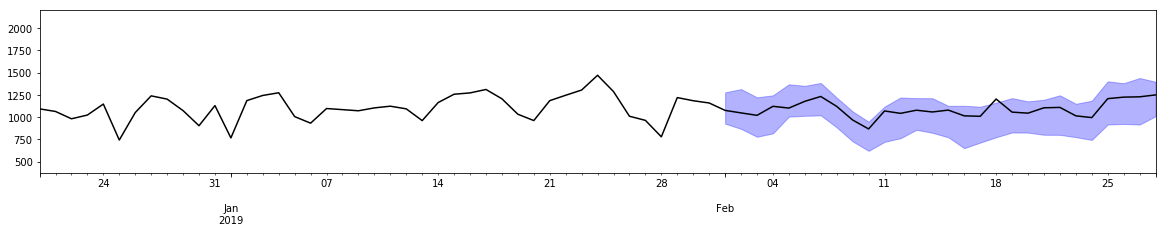

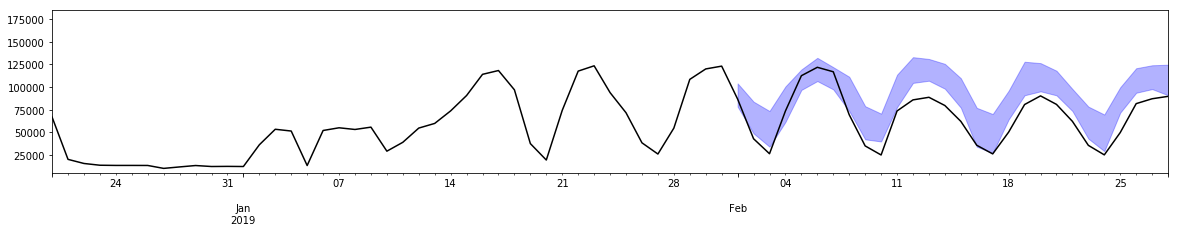

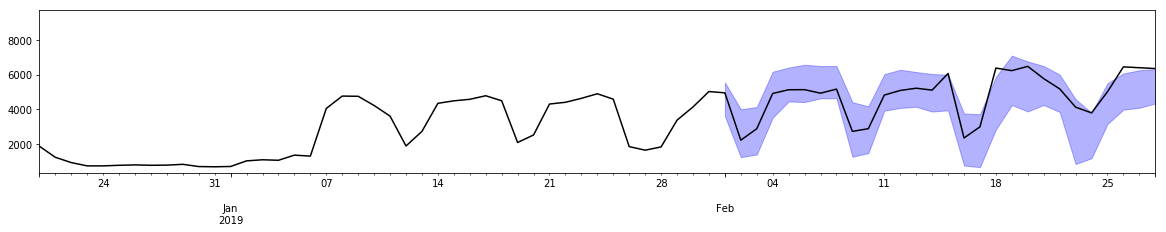

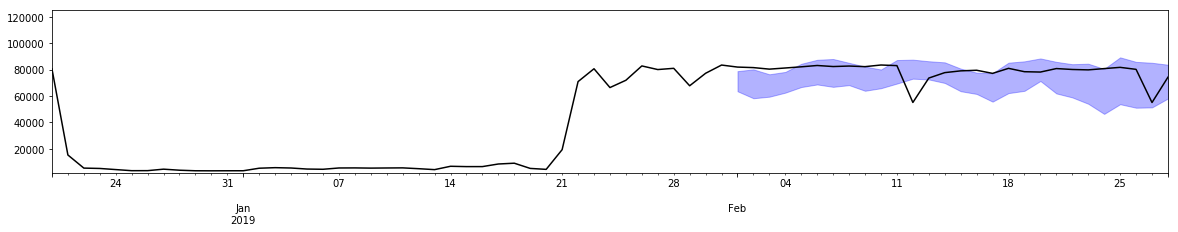

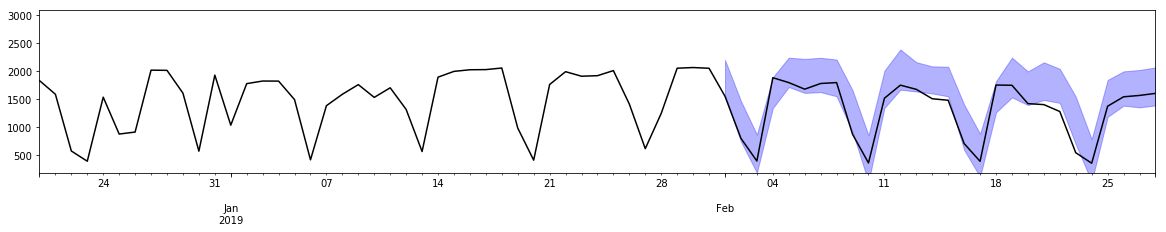

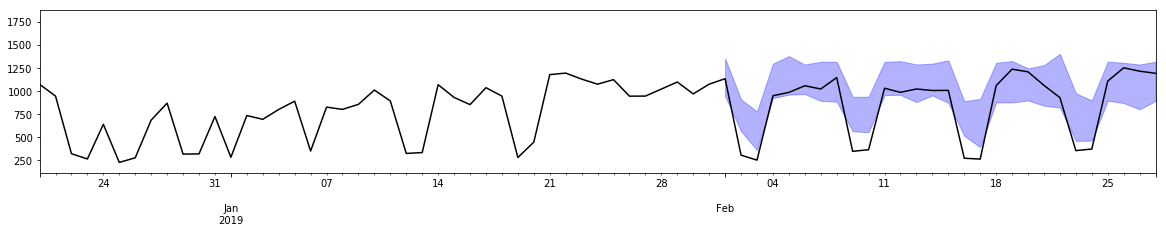

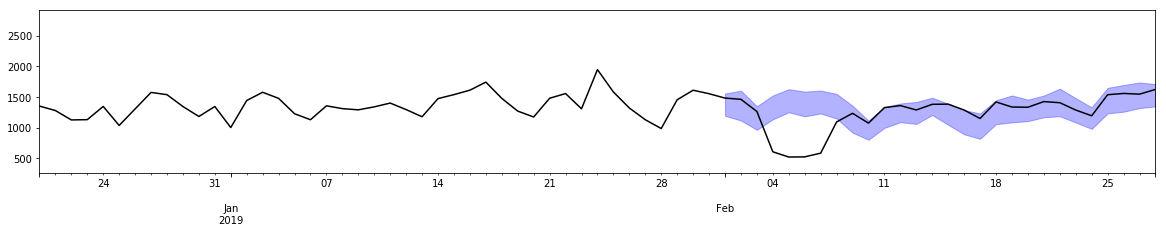

In [33]:
# Plot 4 of each category:
indices = [2,26,33,39,42,47,3]
for i in indices:
    plot_num = indices.index(i)
    plot(
        predictor,
        site_id=i,
        plot_weeks=6,
        confidence=80
    )

## Part 7. Remove the Endpoints

In [34]:
# Comment out this cell if you want the endpoint to exist after "run all"

# Comment out this line if you did NOT run the baseline code:
sess.delete_endpoint('energy-usage-baseline')

sess.delete_endpoint('energy-usage-dynamic')